In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import iqr
from scipy.interpolate import interp1d
from scipy.spatial.distance import jensenshannon
from tqdm import tqdm

In [22]:
def pdf_1(x, mean, var):
    return 1/np.sqrt(2*np.pi*var)*np.exp(-(x-mean)**2/(2*var))

def pdf_2(x, mean, var):
    return 1/np.sqrt(2*np.pi*var)*np.exp(-(x-mean)**2/(2*var))

from scipy.integrate import simps

def compute_analytic_JSD(mean1, var1, mean2, var2):
    xmin = min(mean1 - 5 * np.sqrt(var1), mean2 - 5 * np.sqrt(var2))
    xmax = max(mean1 + 5 * np.sqrt(var1), mean2 + 5 * np.sqrt(var2))
    x_grid = np.linspace(xmin, xmax, 1000000)
    pdf1 = pdf_1(x_grid, mean1, var1)
    pdf2 = pdf_2(x_grid, mean2, var2)
    kl1 = simps((pdf1 * np.log(pdf1 / (0.5 * (pdf1 + pdf2)))), x_grid)
    kl2 = simps((pdf2 * np.log(pdf2 / (0.5 * (pdf1 + pdf2)))), x_grid)
    return 0.5 * (kl1 + kl2)

def compute_analytic_JSD_2(f1, f2):
    x_grid = np.linspace(-10., 10., 1000000)
    pdf1 = f1(x_grid)
    pdf2 = f2(x_grid)
    kl1 = simps((pdf1 * np.log(pdf1 / (0.5 * (pdf1 + pdf2)))), x_grid)
    kl2 = simps((pdf2 * np.log(pdf2 / (0.5 * (pdf1 + pdf2)))), x_grid)
    return 0.5 * (kl1 + kl2)

mean_1, var_1 = 0, 1
mean_2, var_2 = -0.1, 1.2**2
def generate_data_1(N):
    return np.random.normal(mean_1, np.sqrt(var_1), N)

def generate_data_2(N):
    return np.random.normal(mean_2, np.sqrt(var_2), N)
true_jsd = compute_analytic_JSD(mean_1, var_1, mean_2, var_2)
print(true_jsd)
result1 = generate_data_1(10000000)
result2 = generate_data_2(10000000)
jd, f1, f2 = compute_JSD(result1, result2, binning="FD", interpolation="quadratic")
print(jd)

0.00906091160489469
0.00908936918158777


In [23]:
def compute_JSD(result1, result2, interpolation='quadratic', binning="FD"):    
    if binning == "FD":
        number_of_bins_1 = int((result1.max() - result1.min())/(2*iqr(result1)*result1.size**(-1/3)))
    elif binning == "S":
        number_of_bins_1 = int(1 + np.log2(result1.size))
    elif binning == "fuckit50":
        number_of_bins_1 = 50
    if number_of_bins_1 < 5:
        number_of_bins_1 = 5
    nbins1 = np.linspace(result1.min(), result1.max(), number_of_bins_1)

    if binning == "FD":
        number_of_bins_2 = int((result2.max() - result2.min())/(2*iqr(result2)*result2.size**(-1/3)))
    elif binning == "S":
        number_of_bins_2 = int(1 + np.log2(result2.size))
    elif binning == "fuckit50":
        number_of_bins_2 = 50
    if number_of_bins_2 < 5:
        number_of_bins_2 = 5
    nbins2 = np.linspace(result2.min(), result2.max(), number_of_bins_2)
    h, bins = np.histogram(
        result1, density=True, bins=nbins1
    )
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])

    min1, max1 = bin_centres[0], bin_centres[-1]
    fit1 = interp1d(bin_centres, h, kind=interpolation, fill_value=0.0, bounds_error=False)

    h, bins = np.histogram(
        result2, density=True, bins=nbins2
    )
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])
    min2, max2 = bin_centres[0], bin_centres[-1]
    fit2 = interp1d(bin_centres, h, kind=interpolation, fill_value=0.0, bounds_error=False)
    x_grid = np.linspace(min(min1, min2), max(max1, max2), 1000)

    def fit_1(x):
        return max(1e-10, fit1(x))

    def fit_2(x):
        return max(1e-10, fit2(x))


    fit_1 = np.vectorize(fit_1)
    fit_2 = np.vectorize(fit_2)
    # plt.figure()
    # plt.plot(x_grid, fit_1(x_grid))
    # plt.plot(x_grid, fit_2(x_grid))
    # plt.show()

    JSD = jensenshannon(fit_1(x_grid), fit_2(x_grid))**2
    return JSD, fit_1, fit_2

<Figure size 400x400 with 0 Axes>

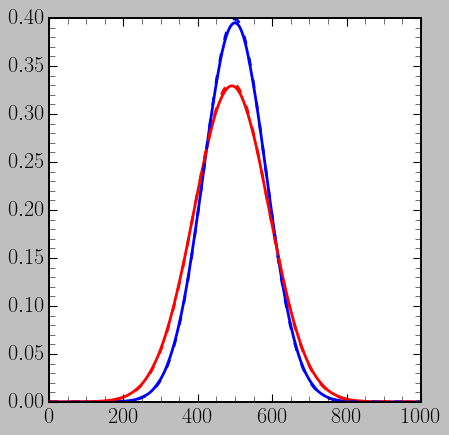

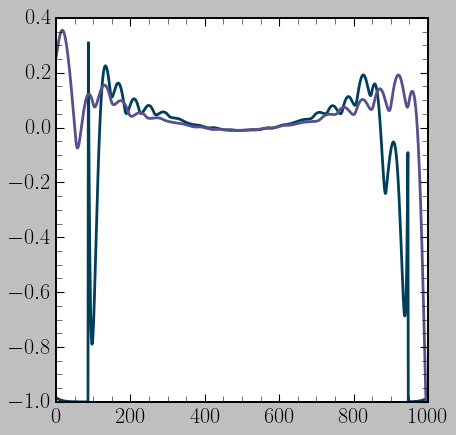

0.009039532657323514


In [24]:
result1 = generate_data_1(10000000)
result2 = generate_data_2(10000000)
jd, f1, f2 = compute_JSD(result1, result2, binning="S", interpolation="quadratic")
plt.figure(figsize=(5, 5))
xg = np.linspace(-6, 6, 1000)
plt.figure()
plt.plot(f1(xg), label='f1', c='b')
plt.plot(f2(xg), label='f2', c='r')
plt.plot(pdf_1(xg, mean_1, var_1), label='f1', c='b', ls='--')
plt.plot(pdf_2(xg, mean_2, var_2), label='f2', c='r', ls='--')
plt.show()
plt.figure()
plt.plot((f1(xg) - pdf_1(xg, mean_1, var_1))/pdf_1(xg, mean_1, var_1), label='f1')
plt.plot((f2(xg) - pdf_2(xg, mean_2, var_2))/pdf_2(xg, mean_2, var_2), label='f2')
plt.show()
print(jd)
#plt.hist(result1, alpha=0.5, bins=np.linspace(-4, 4, 100), density=True, label='data_1')
#plt.hist(result2, alpha=0.5, bins=np.linspace(-4, 4, 100), density=True, label='data_2')

In [26]:
JSDs = []
varJSDs = []
Ns = np.geomspace(10, 100000, 10)
for N in tqdm(Ns):
    this_round_JSDs = []
    for i in range(100):
        result1 = generate_data_1(int(N))
        result2 = generate_data_2(int(N))
        JSD, _, _ = compute_JSD(result1, result2)
        #print(f'N = {N}, JSD = {JSD}')
        this_round_JSDs.append(JSD)
    JSDs.append(np.mean(this_round_JSDs))
    varJSDs.append(np.var(this_round_JSDs))

100%|██████████| 10/10 [00:27<00:00,  2.73s/it]


In [27]:
fdlJSDs = []
fdqJSDs = []
fdcJSDs = []
fdlvarJSDs = []
fdqvarJSDs = []
fdcvarJSDs = []
Ns = np.geomspace(10, 100000, 8)
for N in tqdm(Ns):
    lthis_round_JSDs = []
    qthis_round_JSDs = []
    cthis_round_JSDs = []
    for i in range(50):
        result1 = generate_data_1(int(N))
        result2 = generate_data_2(int(N))
        JSD, _, _ = compute_JSD(result1, result2, interpolation='linear')
        lthis_round_JSDs.append(JSD)
        JSD, _, _ = compute_JSD(result1, result2, interpolation='quadratic')
        qthis_round_JSDs.append(JSD)
        JSD, _, _ = compute_JSD(result1, result2, interpolation='cubic')
        cthis_round_JSDs.append(JSD)
    fdlJSDs.append(np.mean(lthis_round_JSDs))
    fdlvarJSDs.append(np.var(lthis_round_JSDs))
    fdqJSDs.append(np.mean(qthis_round_JSDs))
    fdqvarJSDs.append(np.var(qthis_round_JSDs))
    fdcJSDs.append(np.mean(cthis_round_JSDs))
    fdcvarJSDs.append(np.var(cthis_round_JSDs))

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:28<00:00,  3.61s/it]


In [28]:
flJSDs = []
fqJSDs = []
fcJSDs = []
flvarJSDs = []
fqvarJSDs = []
fcvarJSDs = []
for N in tqdm(Ns):
    lthis_round_JSDs = []
    qthis_round_JSDs = []
    cthis_round_JSDs = []
    for i in range(100):
        result1 = generate_data_1(int(N))
        result2 = generate_data_2(int(N))
        JSD, _, _ = compute_JSD(result1, result2, interpolation='linear', binning='fuckit50')
        lthis_round_JSDs.append(JSD)
        JSD, _, _ = compute_JSD(result1, result2, interpolation='quadratic', binning='fuckit50')
        qthis_round_JSDs.append(JSD)
        JSD, _, _ = compute_JSD(result1, result2, interpolation='cubic', binning='fuckit50')
        cthis_round_JSDs.append(JSD)
    flJSDs.append(np.mean(lthis_round_JSDs))
    flvarJSDs.append(np.var(lthis_round_JSDs))
    fqJSDs.append(np.mean(qthis_round_JSDs))
    fqvarJSDs.append(np.var(qthis_round_JSDs))
    fcJSDs.append(np.mean(cthis_round_JSDs))
    fcvarJSDs.append(np.var(cthis_round_JSDs))

100%|██████████| 8/8 [00:55<00:00,  6.91s/it]


In [29]:
lJSDs = []
qJSDs = []
cJSDs = []
lvarJSDs = []
qvarJSDs = []
cvarJSDs = []
for N in tqdm(Ns):
    lthis_round_JSDs = []
    qthis_round_JSDs = []
    cthis_round_JSDs = []
    for i in range(100):
        result1 = generate_data_1(int(N))
        result2 = generate_data_2(int(N))
        JSD, _, _ = compute_JSD(result1, result2, interpolation='linear', binning="S")
        lthis_round_JSDs.append(JSD)
        JSD, _, _ = compute_JSD(result1, result2, interpolation='quadratic', binning="S")
        qthis_round_JSDs.append(JSD)
        JSD, _, _ = compute_JSD(result1, result2, interpolation='cubic', binning="S")
        cthis_round_JSDs.append(JSD)
    lJSDs.append(np.mean(lthis_round_JSDs))
    lvarJSDs.append(np.var(lthis_round_JSDs))
    qJSDs.append(np.mean(qthis_round_JSDs))
    qvarJSDs.append(np.var(qthis_round_JSDs))
    cJSDs.append(np.mean(cthis_round_JSDs))
    cvarJSDs.append(np.var(cthis_round_JSDs))

100%|██████████| 8/8 [00:55<00:00,  6.90s/it]


/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_58650/1554594856.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 0.15)
/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_58650/1554594856.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 0.15)


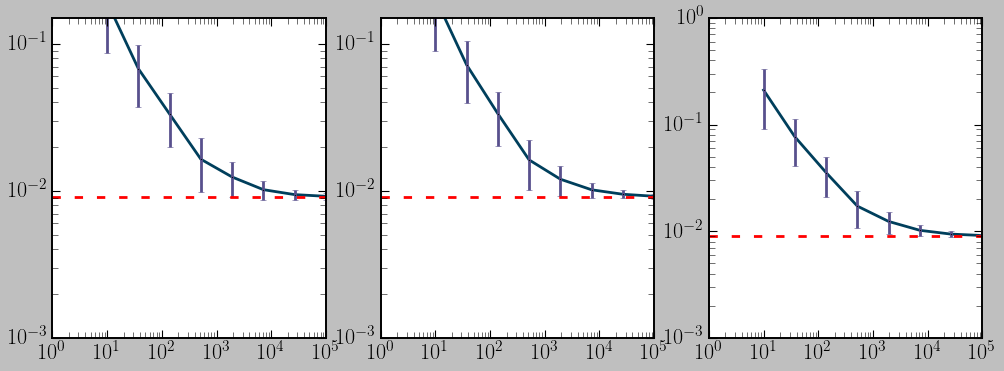

In [30]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 3, 1)
plt.loglog(Ns, lJSDs)
plt.errorbar(Ns, lJSDs, yerr=np.sqrt(np.array(lvarJSDs)), fmt='o')
plt.xlim(1,)
plt.ylim(0, 0.15)
plt.axhline(true_jsd, color='r', linestyle='--')
ax = plt.subplot(1, 3, 2)
plt.loglog(Ns, qJSDs)
plt.errorbar(Ns, qJSDs, yerr=np.sqrt(np.array(qvarJSDs)), fmt='o')
plt.xlim(1,)
plt.ylim(0, 0.15)
plt.axhline(true_jsd, color='r', linestyle='--')
ax = plt.subplot(1, 3, 3)
plt.loglog(Ns, cJSDs)
plt.errorbar(Ns, cJSDs, yerr=np.sqrt(np.array(cvarJSDs)), fmt='o')
plt.xlim(1,)
plt.axhline(true_jsd, color='r', linestyle='--')

/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_58650/874082906.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 0.15)
/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_58650/874082906.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 0.15)
/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_58650/874082906.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 0.15)


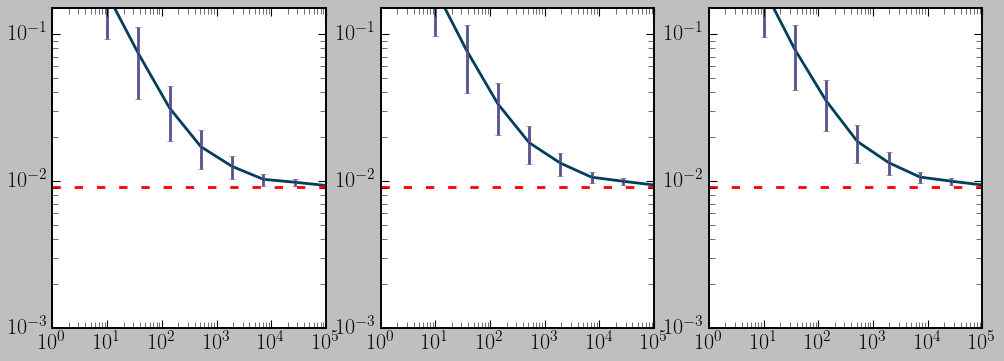

In [32]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 3, 1)
plt.loglog(Ns, fdlJSDs)
plt.errorbar(Ns, fdlJSDs, yerr=np.sqrt(np.array(fdlvarJSDs)), fmt='o')
plt.xlim(1,)
plt.ylim(0, 0.15)
plt.axhline(true_jsd, color='r', linestyle='--')
ax = plt.subplot(1, 3, 2)
plt.loglog(Ns, fdqJSDs)
plt.errorbar(Ns, fdqJSDs, yerr=np.sqrt(np.array(fdqvarJSDs)), fmt='o')
plt.xlim(1,)
plt.ylim(0, 0.15)
plt.axhline(true_jsd, color='r', linestyle='--')
ax = plt.subplot(1, 3, 3)
plt.loglog(Ns, fdcJSDs)
plt.errorbar(Ns, fdcJSDs, yerr=np.sqrt(np.array(fdcvarJSDs)), fmt='o')
plt.xlim(1,)
plt.ylim(0, 0.15)
plt.axhline(true_jsd, color='r', linestyle='--')

/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_58650/815852600.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 0.15)
/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_58650/815852600.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 0.15)
/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_58650/815852600.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 0.15)


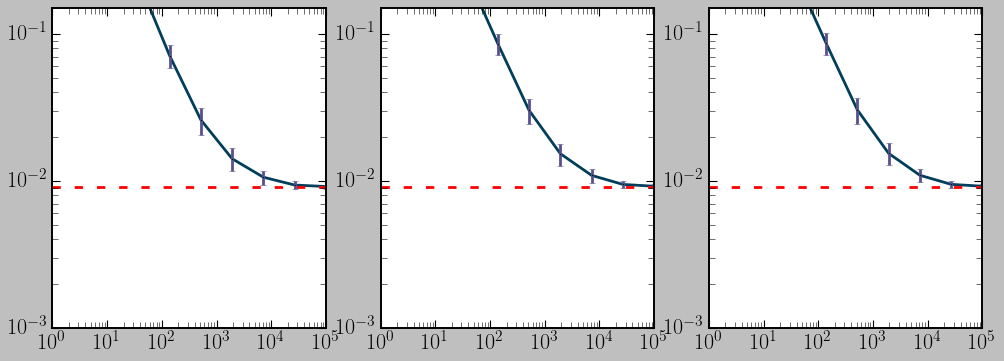

In [33]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 3, 1)
plt.loglog(Ns, flJSDs)
plt.errorbar(Ns, flJSDs, yerr=np.sqrt(np.array(flvarJSDs)), fmt='o')
plt.xlim(1,)
plt.ylim(0, 0.15)
plt.axhline(true_jsd, color='r', linestyle='--')
ax = plt.subplot(1, 3, 2)
plt.loglog(Ns, fqJSDs)
plt.errorbar(Ns, fqJSDs, yerr=np.sqrt(np.array(fqvarJSDs)), fmt='o')
plt.xlim(1,)
plt.ylim(0, 0.15)
plt.axhline(true_jsd, color='r', linestyle='--')
ax = plt.subplot(1, 3, 3)
plt.loglog(Ns, fcJSDs)
plt.errorbar(Ns, fcJSDs, yerr=np.sqrt(np.array(fcvarJSDs)), fmt='o')
plt.xlim(1,)
plt.ylim(0, 0.15)
plt.axhline(true_jsd, color='r', linestyle='--')

/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_58650/1082850644.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 0.15)
/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_58650/1082850644.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 0.15)
/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_58650/1082850644.py:24: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 0.15)


(0.001, 0.15)

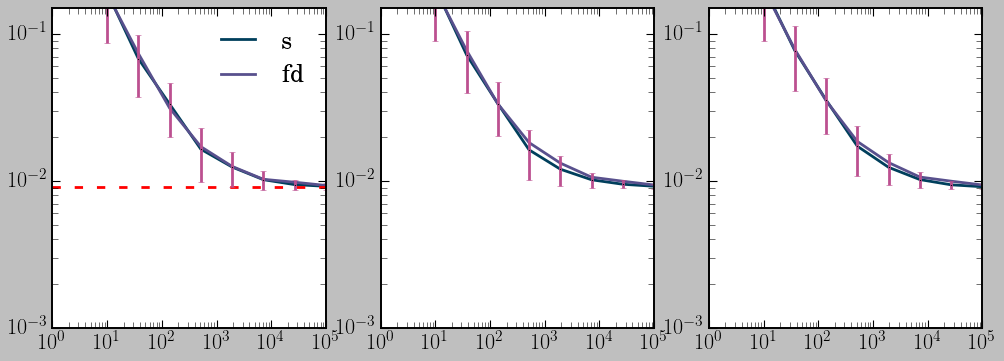

In [34]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 3, 1)
plt.loglog(Ns, lJSDs, label='s')
#plt.loglog(Ns, flJSDs, label='fi50' )
plt.loglog(Ns, fdlJSDs, label='fd')
plt.axhline(true_jsd, color='r', linestyle='--')
plt.errorbar(Ns, lJSDs, yerr=np.sqrt(np.array(lvarJSDs)), fmt='o')
plt.xlim(1,)
plt.ylim(0, 0.15)
plt.legend()
ax = plt.subplot(1, 3, 2)
plt.loglog(Ns, qJSDs)
#plt.loglog(Ns, fqJSDs)
plt.loglog(Ns, fdqJSDs)
plt.errorbar(Ns, qJSDs, yerr=np.sqrt(np.array(qvarJSDs)), fmt='o')
plt.xlim(1,)
plt.ylim(0, 0.15)
ax = plt.subplot(1, 3, 3)
plt.loglog(Ns, cJSDs)
#plt.loglog(Ns, fcJSDs)
plt.loglog(Ns, fdcJSDs)
plt.errorbar(Ns, cJSDs, yerr=np.sqrt(np.array(cvarJSDs)), fmt='o')
plt.xlim(1,)
plt.ylim(0, 0.15)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 33.47it/s]


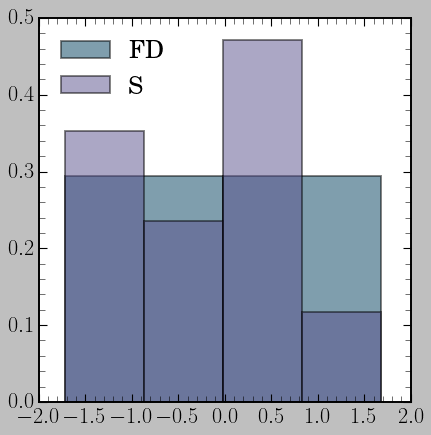

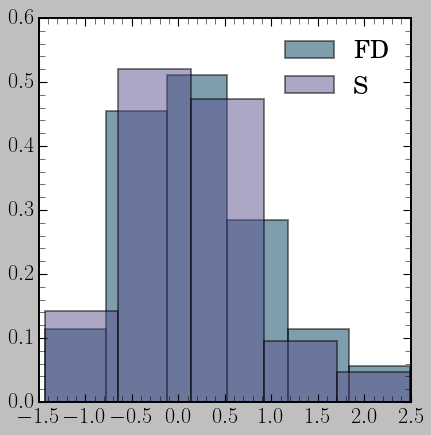

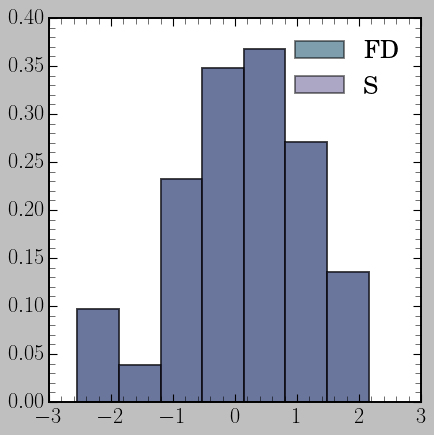

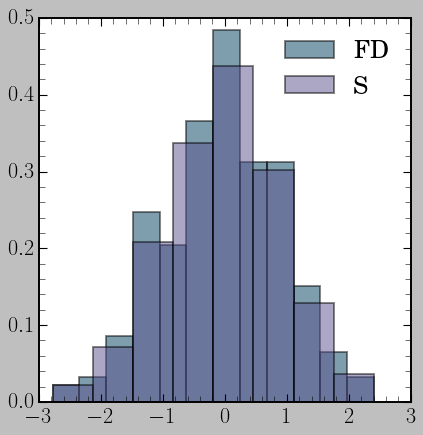

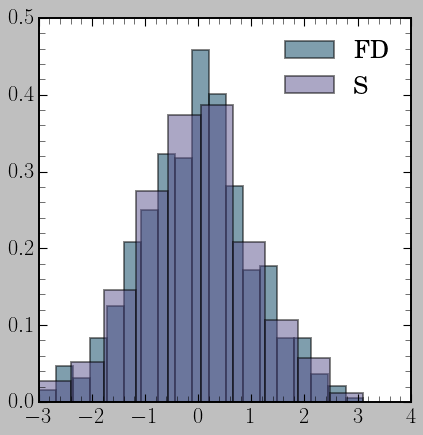

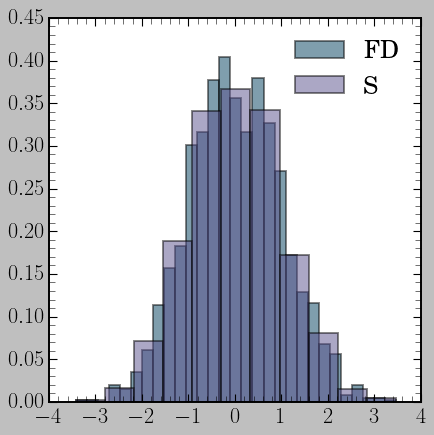

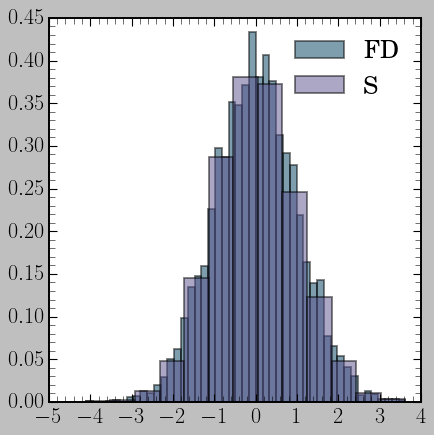

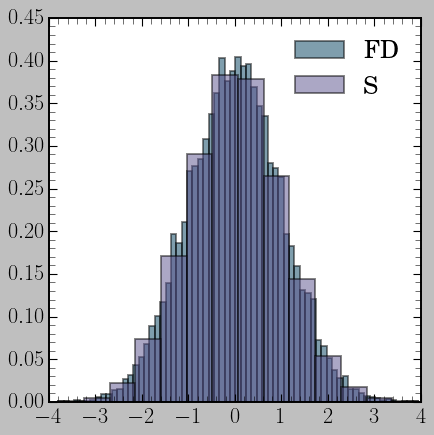

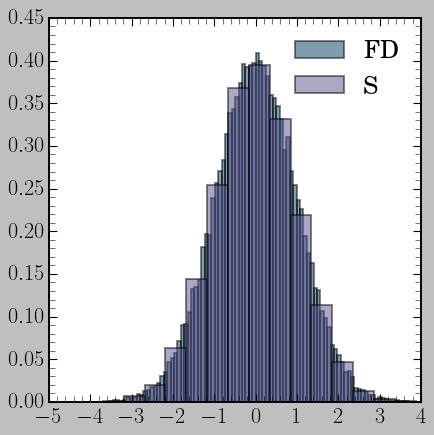

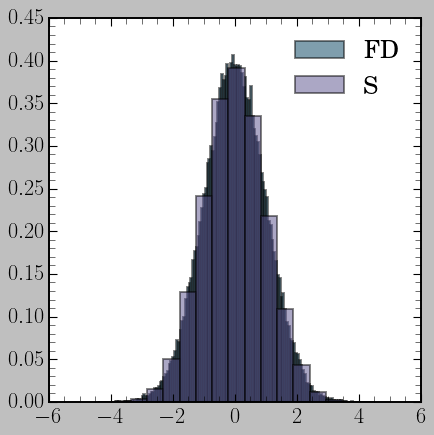

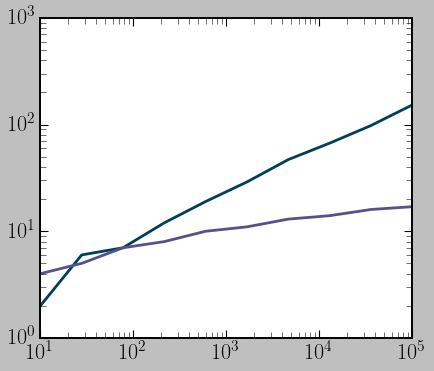

In [35]:
Ns = np.geomspace(10, 100000, 10)
Nfd_bins = []
Ns_bins = []
for N in tqdm(Ns):
    result = generate_data_1(int(N))
    fd_bins = int((result.max() - result.min())/(2*iqr(result)*result.size**(-1/3)))
    s_bins = int(1 + np.log2(result.size))
    Nfd_bins.append(fd_bins)
    Ns_bins.append(s_bins)
    plt.figure()
    plt.hist(result, alpha=0.5, bins=fd_bins, label='FD', density=True)
    plt.hist(result, alpha=0.5, bins=s_bins, label='S', density=True)
    plt.legend()
plt.figure(figsize=(6, 5))
plt.loglog(Ns, Nfd_bins)
plt.loglog(Ns, Ns_bins)